In [1]:
# Load libraries
from skimage.graph import route_through_array
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

# Load CMEMS wave analysis/forecast data 

In [3]:
# Set file path
path = '/home/martin/Projekte/MariData/data/CMEMS/GLOBAL_ANALYSIS_FORECAST_WAV_001_027'
file = os.path.join(path,'global-analysis-forecast-wav-001-027_1613573263374.nc')

In [4]:
# Load netCDF file into xarray
dataset = xr.open_dataset(file)
dataset

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 2)
Coordinates:
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2020-12-01T09:00:00 2020-12-01T12:00:00
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
Data variables:
    VTPK       (time, latitude, longitude) float32 ...
    VHM0       (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:                               CF-1.6
    time_coverage_start:                       20210226-03:00:00
    time_coverage_end:                         20210227-00:00:00
    date_created:                              20210217-07:39:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    product_ref_date:                          20210217-00:00:00
    product_range:                             D+9
    product_user_manual:                       http://marine.copernicus.eu/do...
    quality_information_document:               http://marine.copernicus.eu/d...
    dataset:                                   global-analysis-forecast-wav-0...
    title:                                     Mean fields from global wave m...
    institution:                               METEO-FRANCE
    references:                                http://marine.copernicus.eu
    credit:                                    E.U. Copernicus Marine Service...
    licence:                                   http://marine.copernicus.eu/se...
    contact:                                   servicedesk.cmems@mercator-oce...
    producer:                                  CMEMS - Global Monitoring and ...
    area:                                      GLO
    FROM_ORIGINAL_FILE__geospatial_lon_min:    -180.0
    FROM_ORIGINAL_FILE__geospatial_lon_max:    179.9167
    FROM_ORIGINAL_FILE__geospatial_lon_step:   0.08332825
    FROM_ORIGINAL_FILE__geospatial_lon_units:  degree
    FROM_ORIGINAL_FILE__geospatial_lat_min:    -80.0
    FROM_ORIGINAL_FILE__geospatial_lat_max:    90.0
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

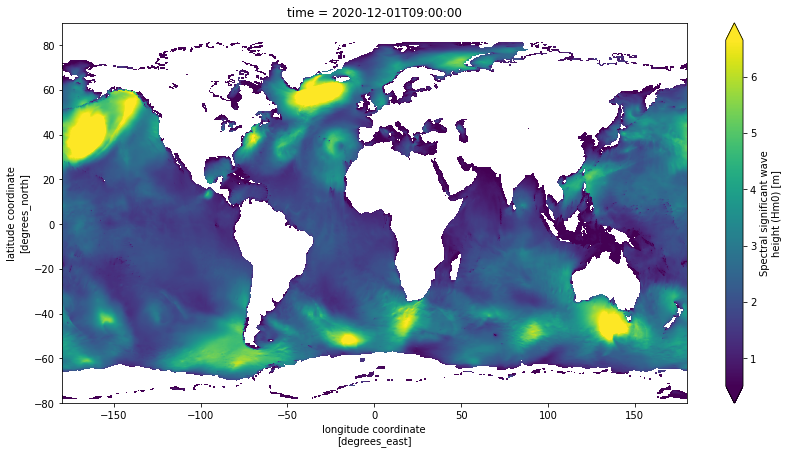

In [5]:
# Plot one variable in the dataset for a specific time slice
dataset.VHM0.isel(time=0).plot(robust=True, aspect=2, size=7);

# Define routing problem

Calculate the optimal shipping route between New York and Lisbon avoiding high waves. <br>

New York: 40.7128° N, 74.0060° W <br>
Lisbon: 38.7223° N, 9.1393° W

### Define area of interest

In [6]:
# Set bounding box for the allowed routing corridor
bbox = ((-80, 32),(-5, 47))
# Select time
time_slice = 0

In [7]:
# Get indices of the bbox
lon_min = get_closest(dataset.longitude.data, bbox[0][0])
lat_min = get_closest(dataset.latitude.data, bbox[0][1])
lon_max = get_closest(dataset.longitude.data, bbox[1][0])
lat_max = get_closest(dataset.latitude.data, bbox[1][1])

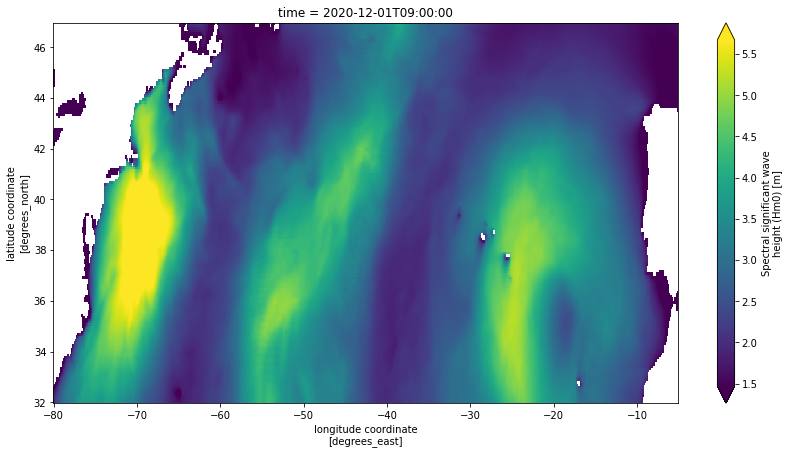

In [8]:
# Extract array from dataset to define the cost in the routing algorithm 
# -> subset space, time and variable
wave_height = dataset.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);

In [9]:
costs = wave_height.data
# Set NaN values to large costs as the algorithm cannot handle NaNs
costs[np.isnan(costs)] = 2 * np.nanmax(costs) 
np.shape(costs)

(180, 900)

### Define start/end point of route 

In [10]:
lat_NY = 40.7128
lon_NY = -74.0060
lat_LS = 38.7223
lon_LS = -9.1393

In [11]:
start_lon = get_closest(wave_height.longitude.data, lon_NY)
start_lat = get_closest(wave_height.latitude.data, lat_NY)
end_lon = get_closest(wave_height.longitude.data,lon_LS)
end_lat = get_closest(wave_height.latitude.data,lat_LS)

In [12]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

# Calculate optimal route (minimum cost path)

In [13]:
# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

indices, weight = route_through_array(costs, start, end, fully_connected=False, geometric=True)
indices = np.stack(indices, axis=-1)
indices

array([[105, 105, 105, ...,  80,  81,  81],
       [ 72,  73,  74, ..., 849, 849, 850]])

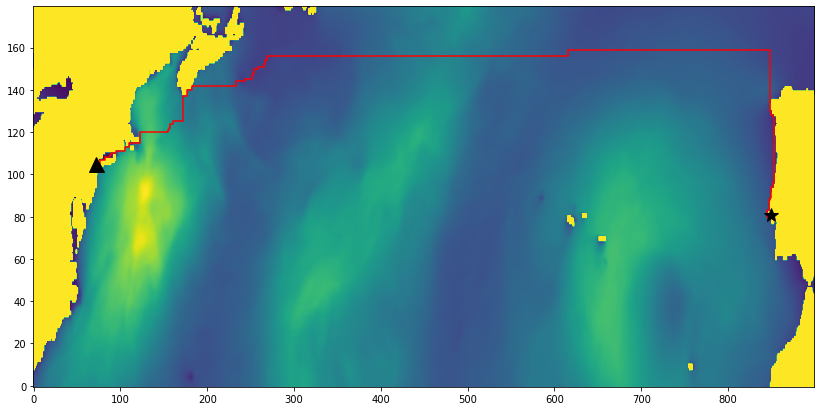

In [14]:
# Plot optimal route

plt.figure(figsize=(14,7))
# Costs
plt.imshow(costs, aspect='auto', vmin=np.min(costs), vmax=0.5*np.max(costs));
# Route
plt.plot(indices[1],indices[0], 'r')
# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize=15)
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.gca().invert_yaxis();